Ion Beam
========

In this notebook, we address the question of the stability of two populations of protons streaming one respect to the other along the local magnetic ﬁeld, a situation often encountered in collisionless plasmas. As we shall see, nature and strength of the instability varies with the plasma parameters (density, magnetic ﬁeld strength, relative velocity, temperature, ...).

In general, an instability arises if a mode exists with phase speed such as to be able
to increase its amplitude by taking the kinetic energy from the beam particles. For
this to happen, phase velocity and beam velocity must be quasi-equal in which case
the mode is said to resonates with the beam.

In [1]:
kinetic_path = "/home/katanovic/fluid_kinetic_class/"
phare_path = "/home/katanovic/PHARE/"

import os
import sys

phare_root = os.path.expanduser(phare_path)
sys.path.append(os.path.join(phare_path, "pyphare"))
sys.path.append(os.path.join(kinetic_path, "2024"))

import matplotlib.pyplot as plt
import numpy as np
from numpy import polyfit
from pyphare.pharesee.hierarchy import fromh5  # was get_times_from_h5
from pyphare.pharesee.run import Run
from scipy.ndimage import gaussian_filter1d as gf
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import scipy as sc
from scripts import dist_plot

sys.path.append("/home/katanovic/fluid_kinetic_class/2024/nb")
from get_get import *
from plot_plot import *

%matplotlib widget

root_path = "/home/katanovic/fluid_kinetic_class/2024/run/beam/"

# Electrostatic case

A particular example of beam instability is the one involving the ion-acoustic mode. This mode is a plasma equivalent of the standard acoustic mode in a compressible gas. Its phase speed is

$$
\left(\frac{\omega}{k} \right)^2 = c_s^2 = \frac{T_e + 3T_p}{m_p}
$$

in a proton-electron plasma. The very fact that the phase speed does not depend on the magnetic ﬁeld, suggest that the mode is a purely electrostatic one, not associated with ﬂuctuations of the magnetic ﬁeld. As already anticipated a beam of protons is potentially
unstable if the phase speed of a plasma mode is roughly the same as the beam velocity. To be more precise, a mode can grow (and be unstable) if its phase speed falls in the velocity interval where the slope of the beam distribution function is positive as shown in the next ﬁgure for the case of the ion acoustic mode with phasespeed $\omega/k = c_s$.

For this first electrostatic case, we consider 2 ion populations that we call `main' and ``beam` :
* for the `main` population, $n_m = 1.0$, $U_m = 0.0$ and $T_m = 0.025$
* for the `beam` population, $n_b = 0.1$, $U_b = 0.7$ and $T_b = 0.025$

The density and pressure of the beam are 0.1 of the values in the main which implies that the ion acoustic propagation speed is essentially given by the main plasma, i.e. $c_s = \sqrt{}T_e + 3 T_m \sim 0.57$

Note that in the simulation (in order to improve statistics for the beam particles) the same number of particles has been used for core and beam. Given that $n_b / n_m = 0.1$, the statistical weight of a main particle is 10 times that of a beam particle.

# Goal

We suggest in this section a single run, but you can the play with both `electron` and `main` temperatures to check the results... But the most unstable mode is the one for which $\gamma(k)$ is maximum. The best way to see this mode is then to have a box length $L_x = 2\pi/k_{\max}$. Hence, playing with $T_e$ and/or $T_m$ is not that simple...

# Run PHARE

- Open a terminal (File>New>Terminal)
- execute `pwd`, you should see `/home/user/PHARE` indicating you're in the PHARE directory
- execute `git clone https://github.com/PHAREHUB/fluid_kinetic_class`
- execute `cd fluid_kinetic_class/2024/run/beam/`


In there you will see a script called `ib1.py` that will configure a PHARE simulation for you.\
To run it, do:

```bash
python3 ib1.py
```

This should run and produce outputs in the directory:

- `ib1/`


To run the analysis for a specific run you did, execute cells below.

# Electrostatic case

### Distribution particles

In [2]:
path = root_path + "ib1"
r = Run(path)

In [3]:
file = os.path.join(r.path, "EM_B.h5")
T = fromh5.get_times_from_h5(file)
dt = T[1]-T[0]

In [4]:
time = 25
main = r.GetParticles(time, ["main"])
beam = r.GetParticles(time, ["beam"])
both = r.GetParticles(time, ["main", "beam"])

(<Figure size 1400x600 with 4 Axes>,
 (<Axes: title={'center': 'Distribution for t = 0'}, xlabel='Vx', ylabel='Vy'>,
  <Axes: title={'center': 'Distribution for t = 99'}, xlabel='Vx', ylabel='Vy'>))

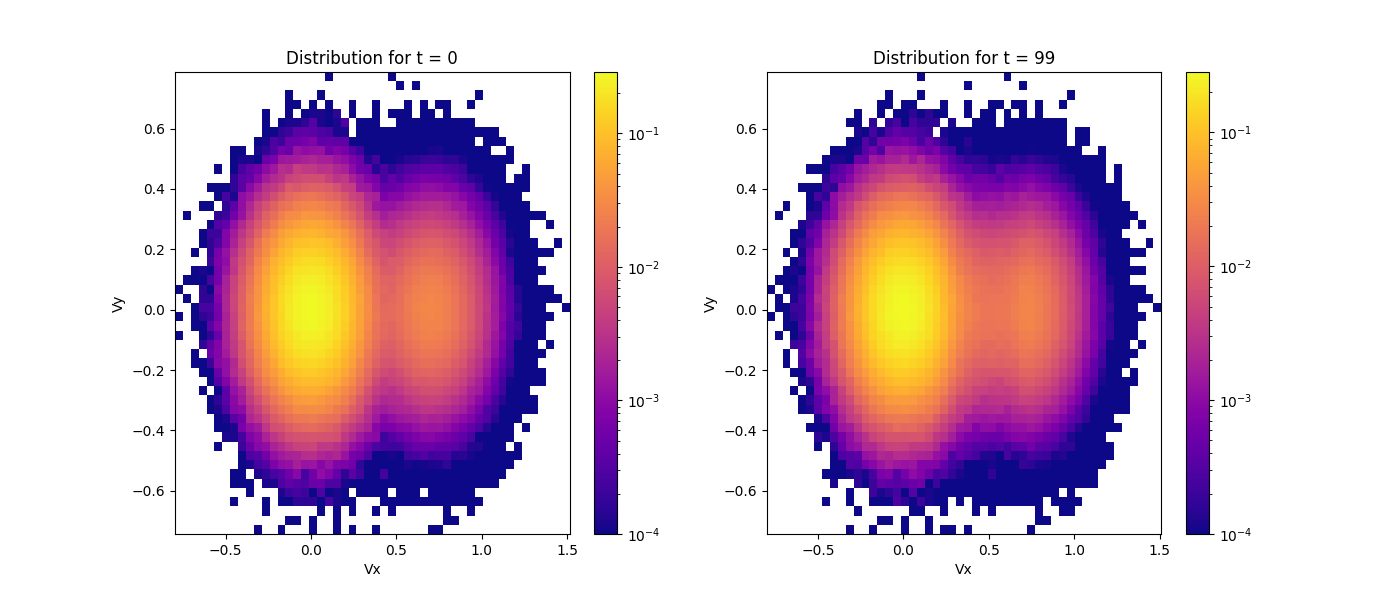

In [5]:
compare_dist_plots(r, "both", axis=("Vx", "Vy"), cmap="plasma")

The gap of speed depends on the temperature of ions. $$ f(v) \propto e^{-v_i² / k_b T_i}$$

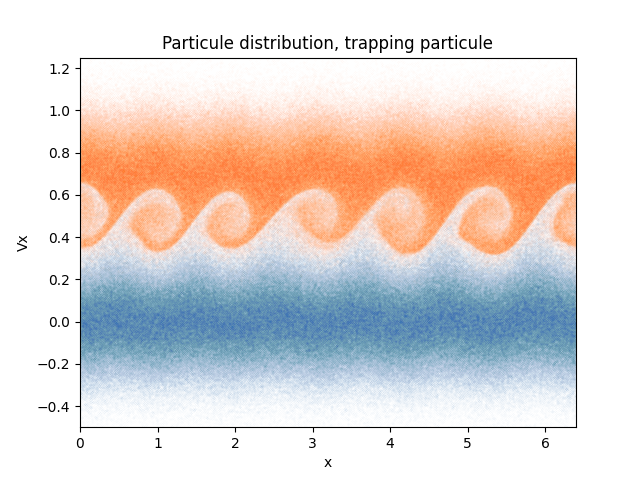

In [6]:
sp_all = dist_plot(both, axis=("x", "Vx"), plot_type="scatter_1", title="Particule distribution")

In the ion acoustic mode, there are two types of particles : circulating and resonance particles. Those resonances particles are particles trapped in the potential electric field, they have a speed defined by : $|v-c_s| < \frac{\Gamma}{k}$.
Waves we can see on the figure above represents the trapping particles.
The following figure shows the distribution particle with the electric field, we can see that it is coordinates with the trapping (green circles for Vx = 0.5).

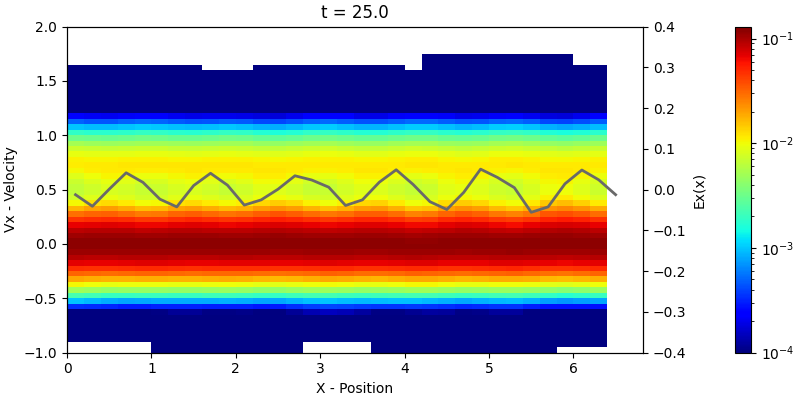

In [7]:
phase_space_ex(time , r)

### Electric field

Ohm's general law is define by : $$\overrightarrow{E} = -\overrightarrow{v} \times \overrightarrow{B} +\eta \overrightarrow{j} - \frac{\overrightarrow{\nabla} P}{en} $$

Because there isn't any magnetic field and we are in 1 dimension, the electric field still can grow due to the density gradient : $E = -\frac{k_b*T*\nabla{n}}{e*n}$

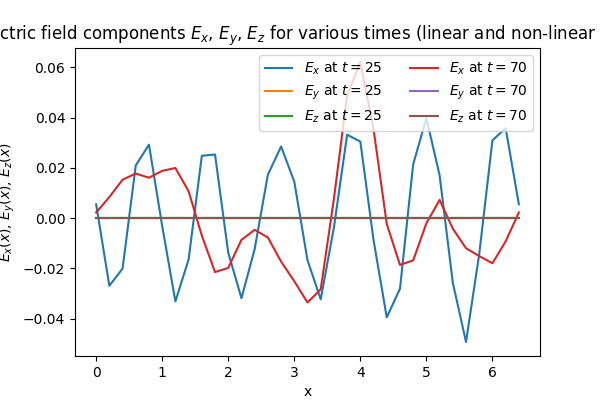

In [8]:
plot_Exyz(r, [25, 70], sigma = 0)

For $t=25$, we can see the 6th mode take the most of the energy available. 

We can verify if the velocity and the density are on phase : $n_i = k/w * v_i$, we also have the velocity phase : $v_{\phi} = \omega / k$

In [9]:
time = [80]
num_mode = 6
x, n = get_densities(r, time, sigma = 0)
n_1, x , energie_mode_n = fourier_series(r, time, num_mode, field="N")

energie_total_n = np.sum(n.real**2/2)
energie_mode_n = np.sum(n_1.real**2/2)
rate_n = energie_mode_n*100/energie_total_n

vx, vy, vz, x = get_velocities(r, time, sigma = 0)
v_1, x , energie_mode_n = fourier_series(r, time, num_mode, field="V", direction="x")

energie_total_v = np.sum(vx.real**2/2)
energie_mode_v = np.sum(v_1.real**2/2)
rate_v = energie_mode_v*100/energie_total_v

/opt/conda/envs/hpc/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/conda/envs/hpc/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


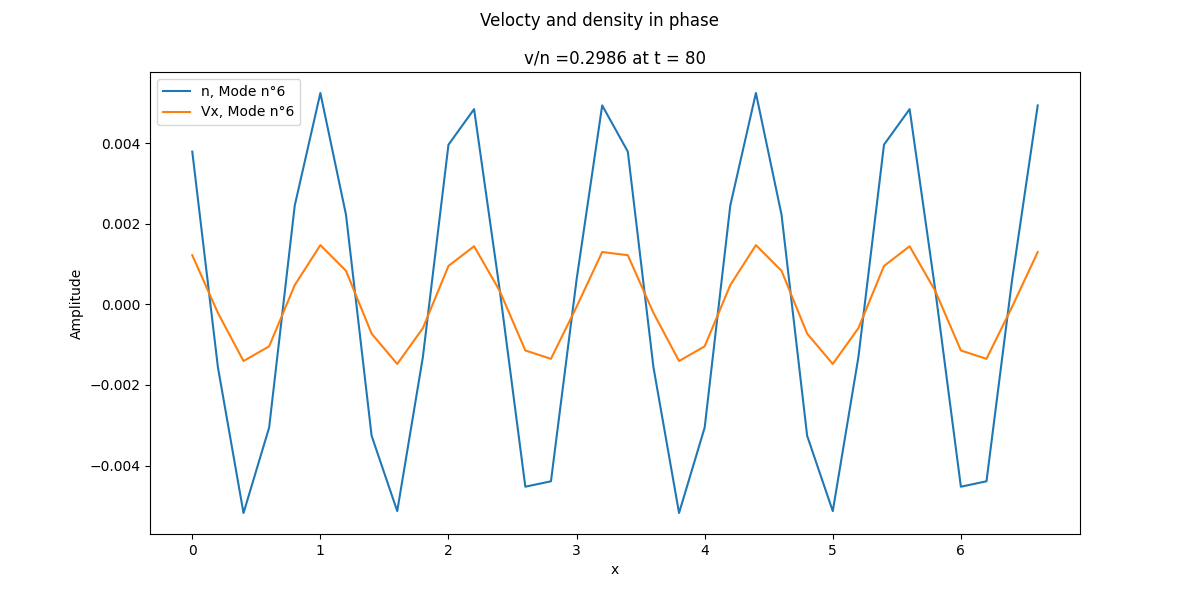

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
fig.suptitle("Velocty and density in phase")
ax.set_title(f"v/n ={ np.mean(v_1/n_1).real:.4f} at t = {time[0]}")
ax.set_xlabel("x")
ax.set_ylabel("Amplitude")
ax.plot(x, n_1, label=f"n, Mode n°{num_mode}")
ax.plot(x, v_1, label=f"Vx, Mode n°{num_mode}")
ax.legend()

The electric field is in quadrature (disphase of $\pi/2$) with the density and the velocity.
$$
mn\frac{\partial{v}}{\partial{t}} = enE
$$
$$
i\omega v = - E \qquad v = \frac{1}{\omega}* E * e^{i\pi/2}
$$

In [11]:
e_1, x, energy = fourier_series(r, time, num_mode, field="E", direction="x")

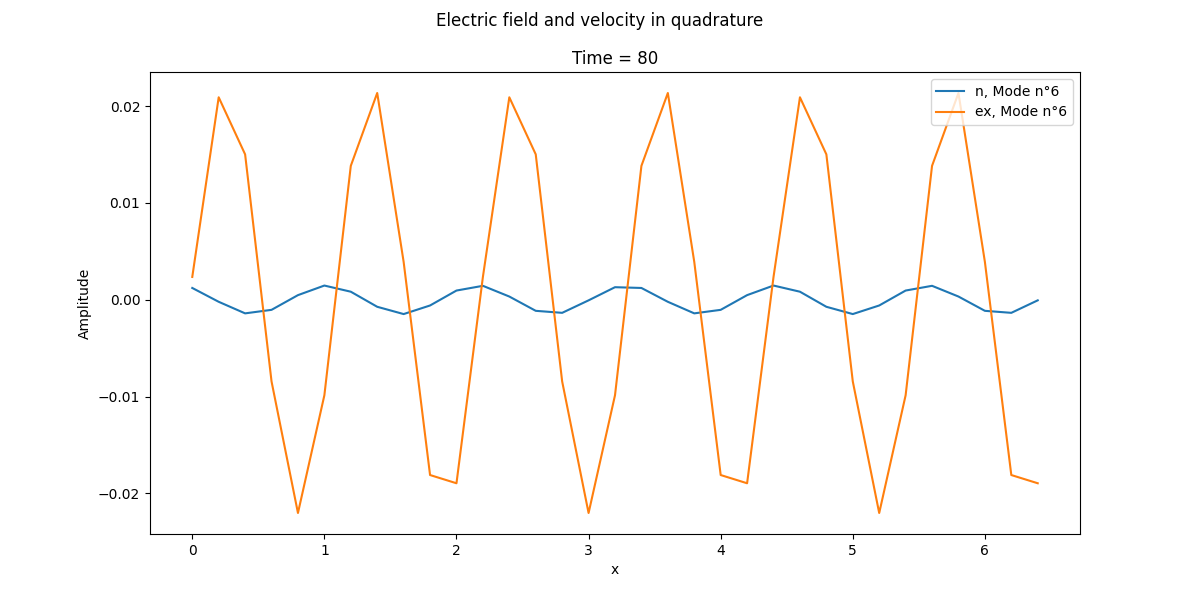

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
fig.suptitle(f"Electric field and velocity in quadrature")
ax.set_title(f"Time = {time[0]}")
ax.set_xlabel("x")
ax.set_ylabel("Amplitude")
ax.plot(x, v_1[:-1], label=f"n, Mode n°{num_mode}")
ax.plot(x, e_1*5, label=f"ex, Mode n°{num_mode}")
ax.legend()

### Growing modes

By using the variations of the electric field, we can draw the different modes and deduce the growth factor $\gamma$. We use the Fourier transformation to calculate it.
Reminder : $E, n, v \propto e^{\gamma t} e^{i(kx-wt)}$

Text(0.5, 0, 'Time')

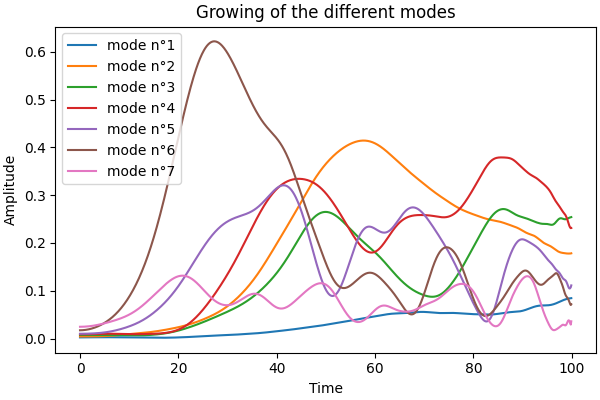

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)

for i in range(7):
    mode, times = modes_E(path, i)
    ax.plot(times, mode, label=f"mode n°{i+1}")

ax.legend()
ax.set_ylabel("Amplitude")
ax.set_title("Growing of the different modes")
ax.set_xlabel("Time")

As we can see, the most growing mode is the 6th. This mode will take most of the energy, specially between t = 20 and t = 30. We have the answer of why the 6th mode was discernible at t=25.

By using a fit curve on the linear part, we can deduce the growth rate $\gamma$.

In [14]:
num = 5
mode, times = modes_E(path, num)
ioffset = 100
imax = find_peaks(mode)[0][0]
p, c = curve_fit(yaebx, times[:imax-ioffset], mode[:imax-ioffset],p0=[0.08,0.09])
ampli, gamma = p
a = mode
b = yaebx(times, ampli, gamma)
diff = a-b
for i in range(diff.size):
    if np.abs(diff[i]) > 0.025:
        break

Text(0, 0.5, 'Amplitude')

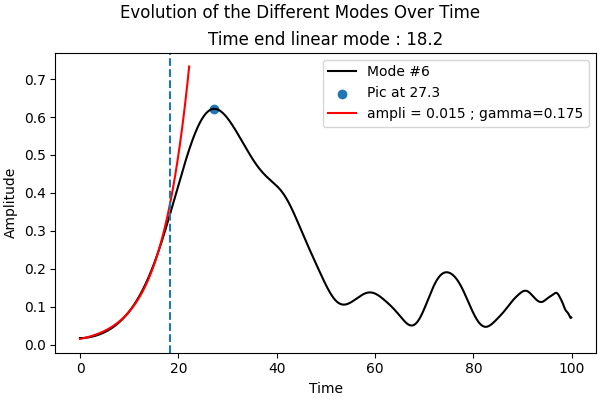

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
ax.plot(times, mode, label=f"Mode #{num+1}", c="black")
ax.scatter(times[imax], mode[imax], label=f"Pic at {times[imax]}")
ax.set_title(f"Time end linear mode : {times[i]}")
ax.plot(times[:imax-50], yaebx(times[:imax-50],ampli, gamma), label=f"ampli = {ampli:.3f} ; gamma={gamma:.3f}", c="red", ls="-")
ax.axvline(times[i], ls="--")
ax.legend()
fig.suptitle("Evolution of the Different Modes Over Time")
ax.set_xlabel("Time")
ax.set_ylabel("Amplitude")

In [16]:
num = 1
mode, times = modes_E(path, num)
imax = find_peaks(mode)[0][0]
p, c = curve_fit(yaebx, times[:imax-ioffset], mode[:imax-ioffset],p0=[0.08,0.09])
ampli, gamma = p
a = mode
b = yaebx(times, ampli, gamma)
diff = a-b
for i in range(diff.size):
    if np.abs(diff[i]) > 0.025:
        break

Text(0, 0.5, 'Amplitude')

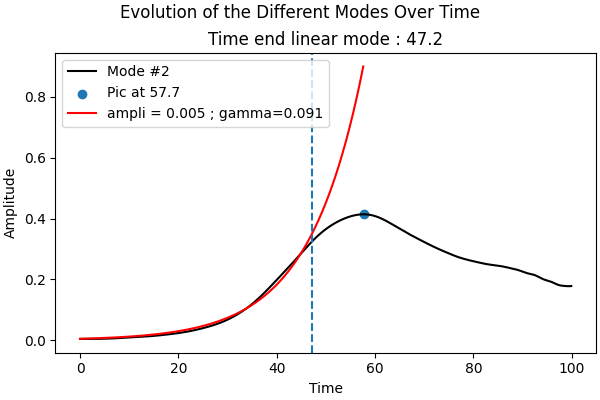

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
ax.plot(times, mode, label=f"Mode #{num+1}", c="black")
ax.scatter(times[imax], mode[imax], label=f"Pic at {times[imax]}")
ax.set_title(f"Time end linear mode : {times[i]}")
ax.plot(times[:imax], yaebx(times[:imax],ampli, gamma), label=f"ampli = {ampli:.3f} ; gamma={gamma:.3f}", c="red", ls="-")
ax.axvline(times[i], ls="--")
ax.legend()
fig.suptitle("Evolution of the Different Modes Over Time")
ax.set_xlabel("Time")
ax.set_ylabel("Amplitude")

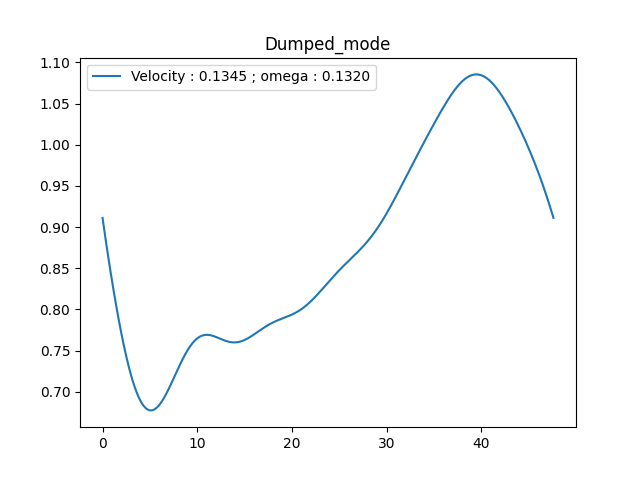

In [18]:
dumped_mode = damped_mode = mode[: imax - ioffset] * yaebx(
        times[: imax - ioffset], 1 / ampli, -gamma)
omegas = np.fabs(np.fft.fft(damped_mode).real)
omega = (
    0.5
    * (omegas[1 : (omegas.size // 2)+1].argmax() + 1)
    * 2
    * np.pi
    / times[imax - 1 - ioffset]
)
k = 2*np.pi*num/(r.GetDomainSize()[0])
v_phase = omega/k
fig, ax = plt.subplots(1,1)
ax.set_title("Dumped_mode")
ax.plot(times[:imax-ioffset], dumped_mode, label=f"Velocity : {v_phase:.4f} ; omega : {omega:.4f}")
ax.legend()

Because the ion acoustic mode hasn't any magnetic field, we can watch the wave propagation by using the density, the electric field Ex or the velocity. Here, we will do with the density, but we would have the same results with those other quantities.

In [19]:
#times = np.asarray([0, 1, 2, 25, 26, 27, 80, 81, 82])
#m, x= plot_densities(r, times, sigma = 0)

By using Fourier transformations, we can split the electric fields (or other) into wave mode.
We can now calculate the rate of the energy of the most dominante mode wave.

In [20]:
time = [18.2]

ex, ey, ez , x= get_E(r, time, sigma=0)

ex_k = np.fft.fft(ex, axis = 0)

mode_indice = 2
ex_k_6 = np.zeros_like(ex_k, dtype= complex)

ex_k_6[mode_indice,:] = ex_k[mode_indice,:]
ex_k_6[-mode_indice, :] = ex_k[-mode_indice, :]

ex_6 = np.fft.ifft(ex_k_6, axis = 0)

energie_total = np.sum(ex.real**2/2)
energie_mode = np.sum(ex_6.real**2/2)
rate = energie_mode*100/energie_total

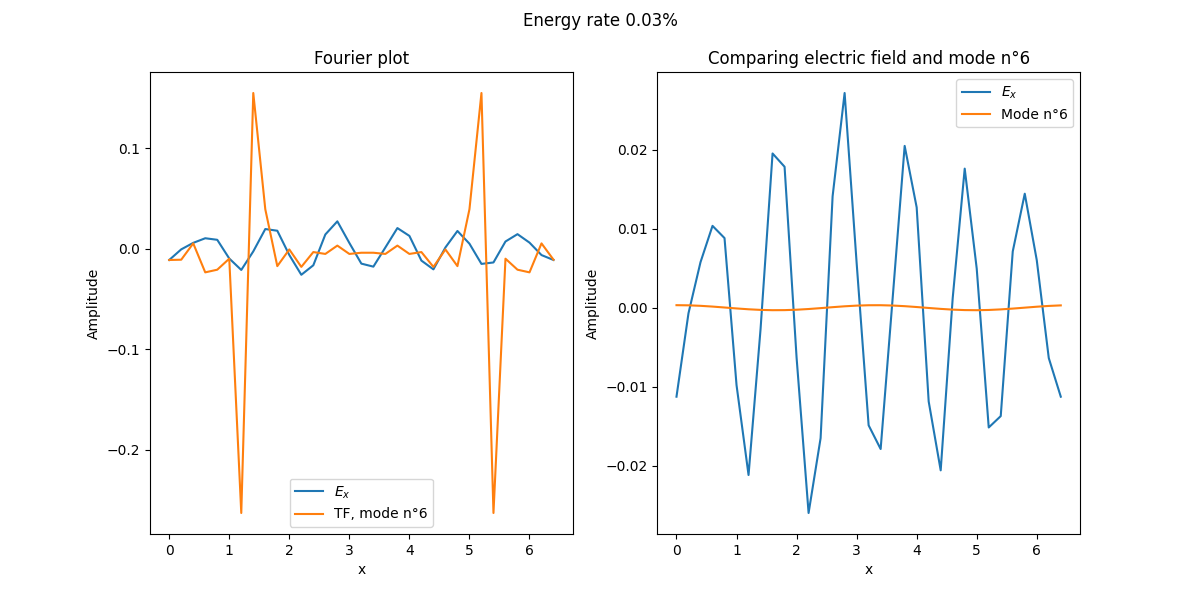

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle(f"Energy rate {rate:.2f}%")
ax[0].set_title("Fourier plot")
ax[0].set_xlabel("x")
ax[0].set_ylabel("Amplitude")
ax[0].plot(x, ex, label="$E_x$")
ax[0].plot(x, ex_k, label=f"TF, mode n°{np.argmax(np.abs((ex_k[:(ex_k.size // 2)])))}")

ax[1].set_title("Comparing electric field and mode n°6")
ax[1].plot(x, ex, label="$E_x$")
ax[1].plot(x, ex_6, label="Mode n°6")
ax[1].set_xlabel("x")
ax[1].set_ylabel("Amplitude")
ax[0].legend()
ax[1].legend()

If we add all modes, we come back to (almost) the original wave.

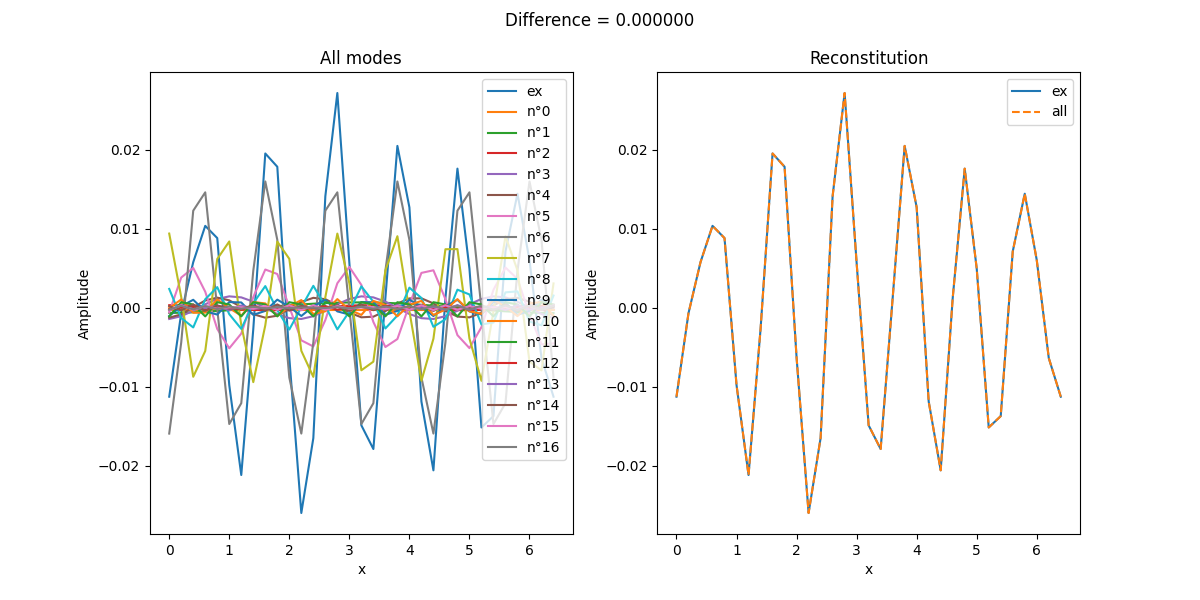

In [22]:
ex, ey, ez , x = get_E(r, time, sigma=0)

ex_k = np.fft.fft(ex, axis = 0)
all = np.zeros_like(ex_k, dtype=complex)

fig, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].plot(x, ex, label="ex")
ax[1].plot(x, ex, label="ex")

for i in range(ex_k.size //2 +1):
    mode_indice = i
    ex_k_i = np.zeros_like(ex_k, dtype= complex)
    
    ex_k_i[mode_indice,:] = ex_k[mode_indice,:]
    ex_k_i[-mode_indice, :] = ex_k[-mode_indice, :]
    
    ek = np.fft.ifft(ex_k_i, axis = 0)
    all += ek
    ax[0].plot(x, ek, label=f"n°{i}")


ax[0].legend()
ax[0].set_title("All modes")
ax[0].set_xlabel("x")
ax[0].set_ylabel("Amplitude")

ax[1].set_title("Reconstitution")
ax[1].plot(x, all, label = "all", ls="--")
ax[1].set_xlabel("x")
ax[1].set_ylabel("Amplitude")
fig.suptitle(f"Difference = {np.sum(np.abs(all.real - ex.real))/all.size:.6f}")
ax[1].legend()

/opt/conda/envs/hpc/lib/python3.10/site-packages/scipy/signal/_peak_finding.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


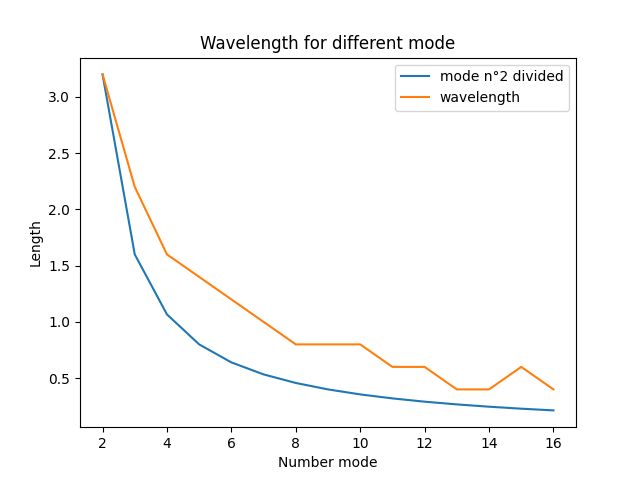

In [23]:
time = [95]
dt = 0.1
dx = []

m, n, o = fourier_series(r, time, 2,  field="E", direction = "x")
p = find_peaks(m[:,0])[0][0]
w = find_peaks(m[:,0])[0][1]
dy = []

for i in range(2, int(r.GetDomainSize()/(0.2*2)+1)):
    fs, x , energy = fourier_series(r, time, i, field="E", direction = "x")
    peaks = find_peaks(gf(fs[:,0], 1))[0]
    a = peaks[0]
    b = peaks[1]
    dx.append(x[b]-x[a])
    dy.append((n[w]-n[p])/(i-1))

l = np.arange(2, int(r.GetDomainSize()/(0.2*2)+1), 1)
fig, ax = plt.subplots(1,1)
ax.set_title("Wavelength for different mode")
ax.set_xlabel("Number mode")
ax.set_ylabel("Length")
ax.plot(l,dy, label="mode n°2 divided")
ax.plot(l,dx, label="wavelength")
ax.legend()

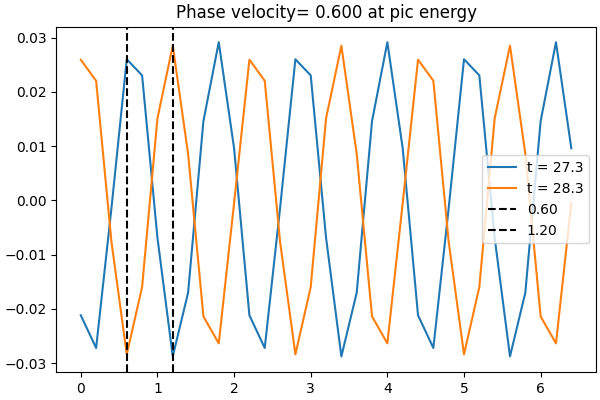

In [24]:
mode = 6
time = [27.3]
fs1, x, energy = fourier_series(r, time, mode, field="E", direction="x")
a = find_peaks(fs1[:,0])[0][0]

time = [28.3]
fs2, x, energy = fourier_series(r, time, mode, field="E", direction="x")
b = find_peaks(fs2[:,0])[0][0]

print()
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
ax.set_title(f"Phase velocity= {(x[b]-x[a]):.3f} at pic energy")
ax.plot(x, fs1, label="t = 27.3" )
ax.plot(x, fs2, label="t = 28.3")
ax.axvline(x[a], c="black", ls="--", label=f"{x[a]:.2f}")
ax.axvline(x[b], c="black", ls="--", label=f"{x[b]:.2f}")
ax.legend()

Text(0.5, 0, 'Time')

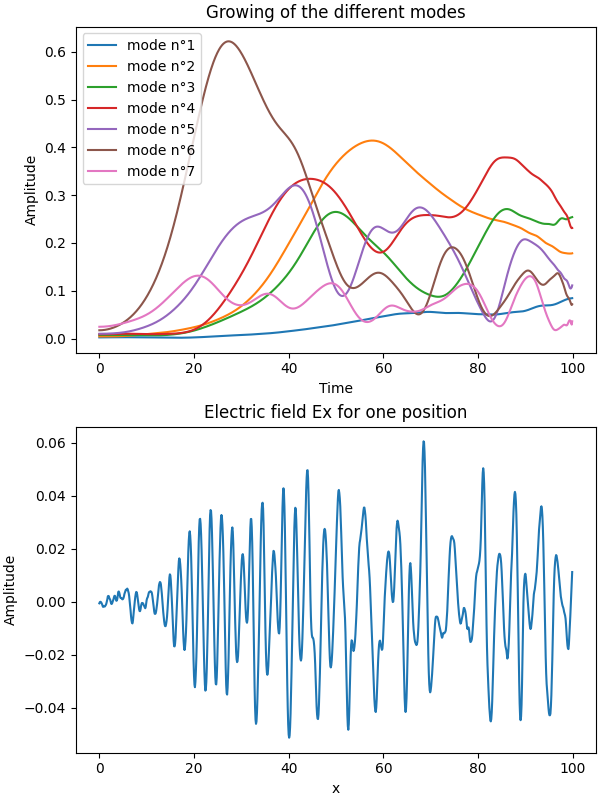

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8), constrained_layout=True)

for i in range(7):
    mode, times = modes_E(path, i)
    ax[0].plot(times, mode, label=f"mode n°{i+1}")
file = os.path.join(r.path, "EM_B.h5")
times = fromh5.get_times_from_h5(file)
ex, ey, ez, x = get_E(r, times, sigma = 0)
z = 16
ax[1].set_title("Electric field Ex for one position")
ax[1].plot(times, ex[z,:])
ax[1].set_xlabel("x")
ax[1].set_ylabel("Amplitude")
ax[0].legend()
ax[0].set_ylabel("Amplitude")
ax[0].set_title("Growing of the different modes")
ax[0].set_xlabel("Time")

fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
ax.plot(times, ey[z,:])
ex_w = np.fft.fft(ey[z,:])
T = np.array([])
all = np.zeros_like(ex_w, dtype=complex)
for i in range(0, 500):
    mode_indice = i
    ex_w_6 = np.zeros_like(ex_w, dtype= complex)
    ex_w_6[mode_indice] = ex_w[mode_indice]
    ex_w_6[-mode_indice] = ex_w[-mode_indice]
    ex_6 = np.fft.ifft(ex_w_6)
    all += ex_6
    ax.plot(times, ex_6)
ax.plot(times, all, c="black", ls="--")

# Energy

In [26]:
times = np.arange(27, 30, 1)

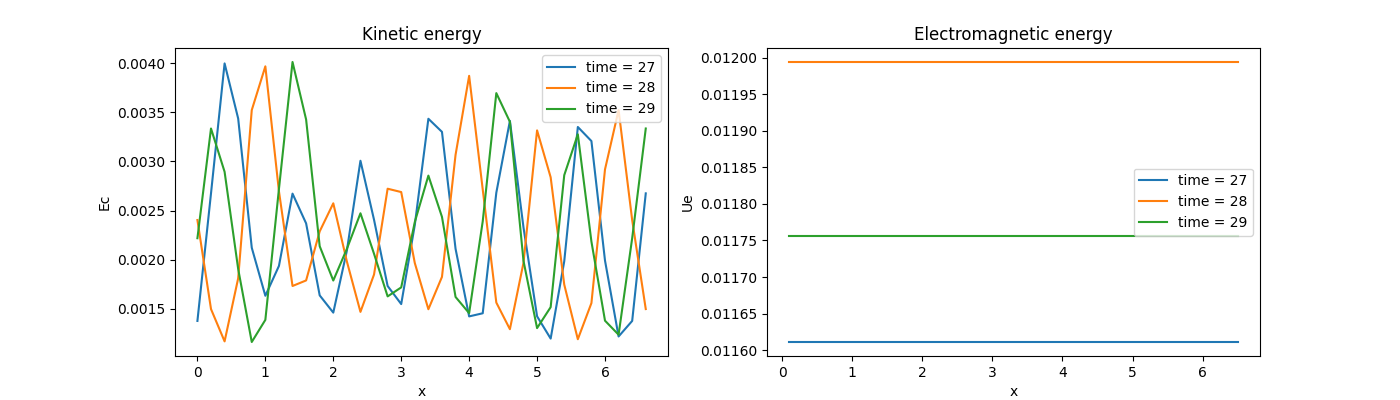

In [27]:
Ec , ue = plot_ec_ue(r, times, sigma =0)

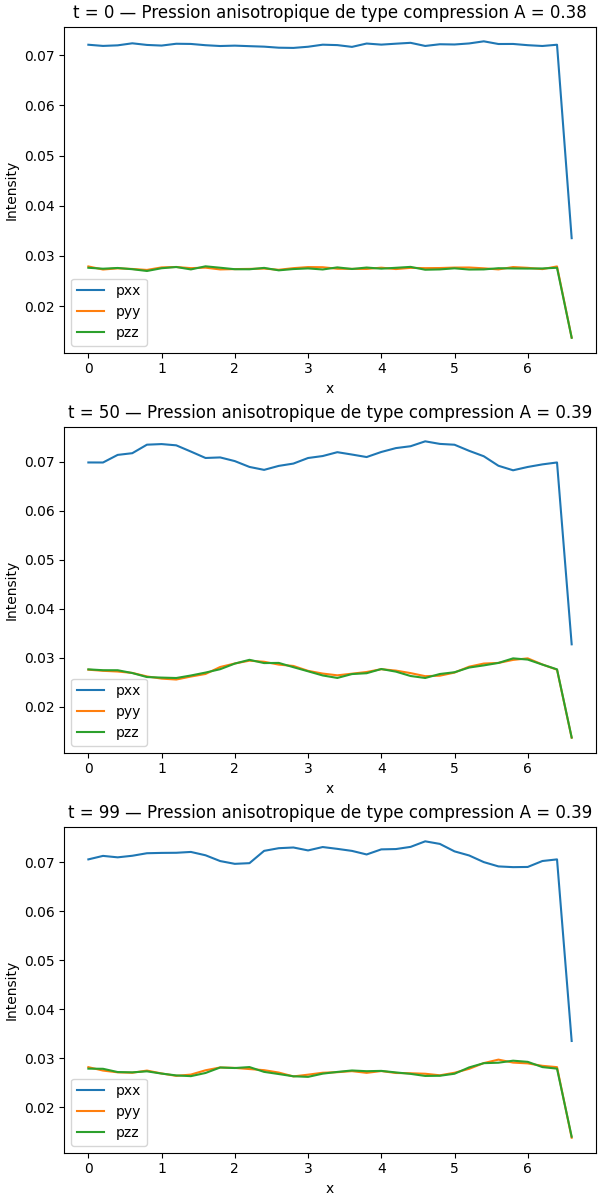

In [28]:
times = np.array([0, 50, 99])  
plot_pressure(r, times, sigma=0.01)

# Run PHARE

 ```bash
python3 ib2.py
```

This should run and produce outputs in the directory:

- `ib2/`


To run the analysis for a specific run you did, execute cells below.

We are going to look at a electromagnetic case. We add a magnetic field on the x axis. 

# Electromagnetic case

The following figures illustrates the particle distribution at the beginning and at the end of the simulation. It is interesting to see how the beam particles tend to describe a circle around the center in the phase velocity.

In [29]:
path = root_path + "/" + "ib2"
r = Run(path)

In [30]:
time = 99
main = r.GetParticles(time, ["main"])
beam = r.GetParticles(time, ["beam"])
both = r.GetParticles(time, ["main", "beam"])

(<Figure size 1400x600 with 4 Axes>,
 (<Axes: title={'center': 'Distribution for t = 0'}, xlabel='Vx', ylabel='Vy'>,
  <Axes: title={'center': 'Distribution for t = 99'}, xlabel='Vx', ylabel='Vy'>))

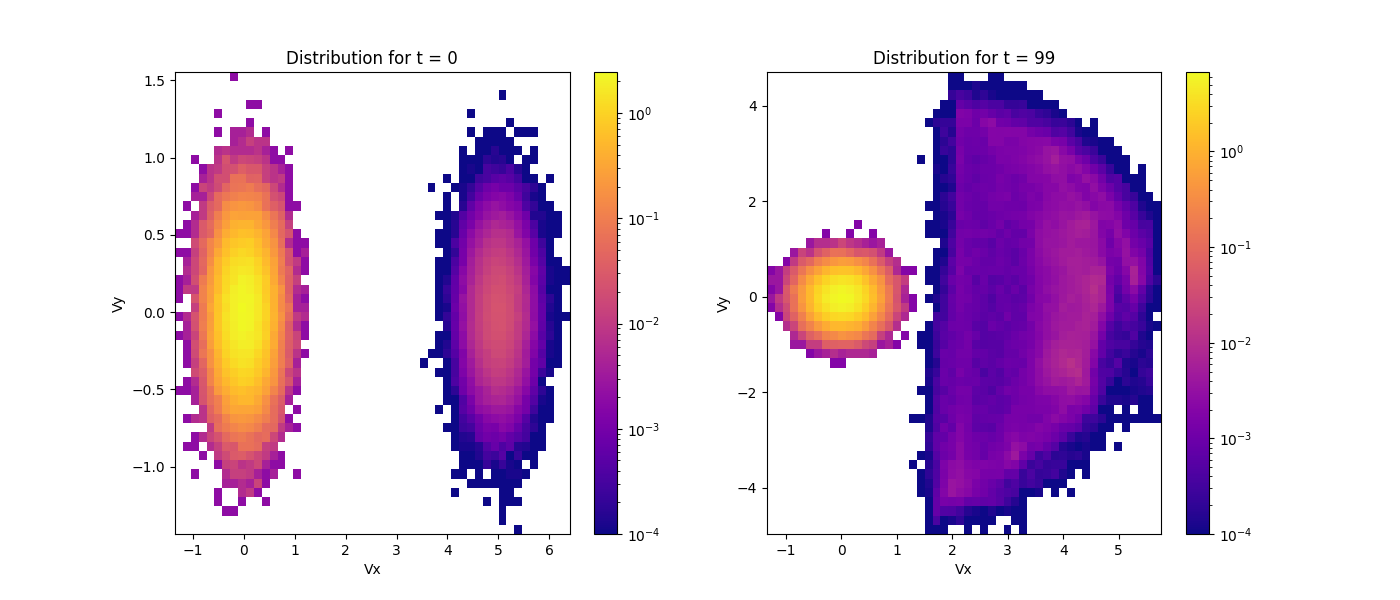

In [31]:
compare_dist_plots(r, "both", axis=("Vx", "Vy"), cmap="plasma")

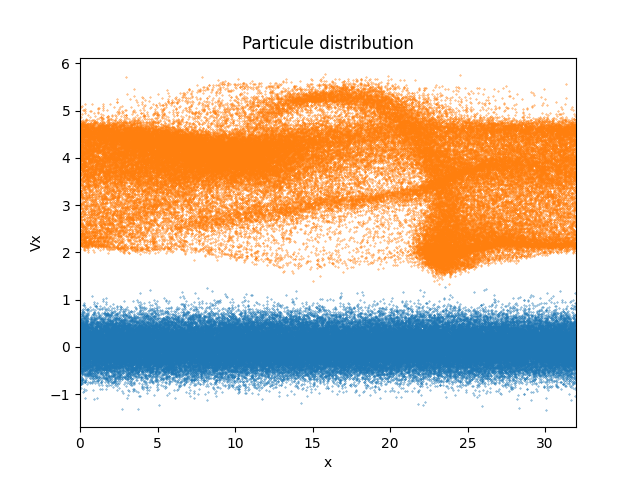

In [32]:
x_, v_ = dist_plot(both, axis=("x", "Vx"), plot_type="scatter_2", title="Particule distribution")

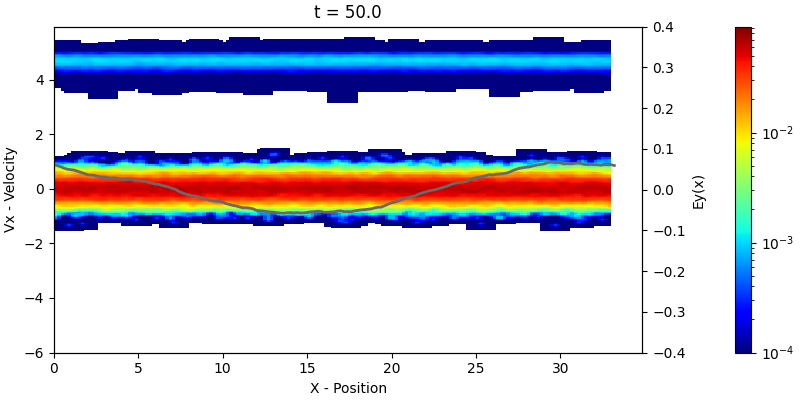

In [33]:
phase_space_ey(50, r) #Max time_offset = 99.9

# Characteristic of an instastability

An instability is characterized by the growing of some physical quantities to the detriment of others. Most of the time, the magnetic fields will grow through time.

/home/katanovic/fluid_kinetic_class/2024/nb/plot_plot.py:149: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)


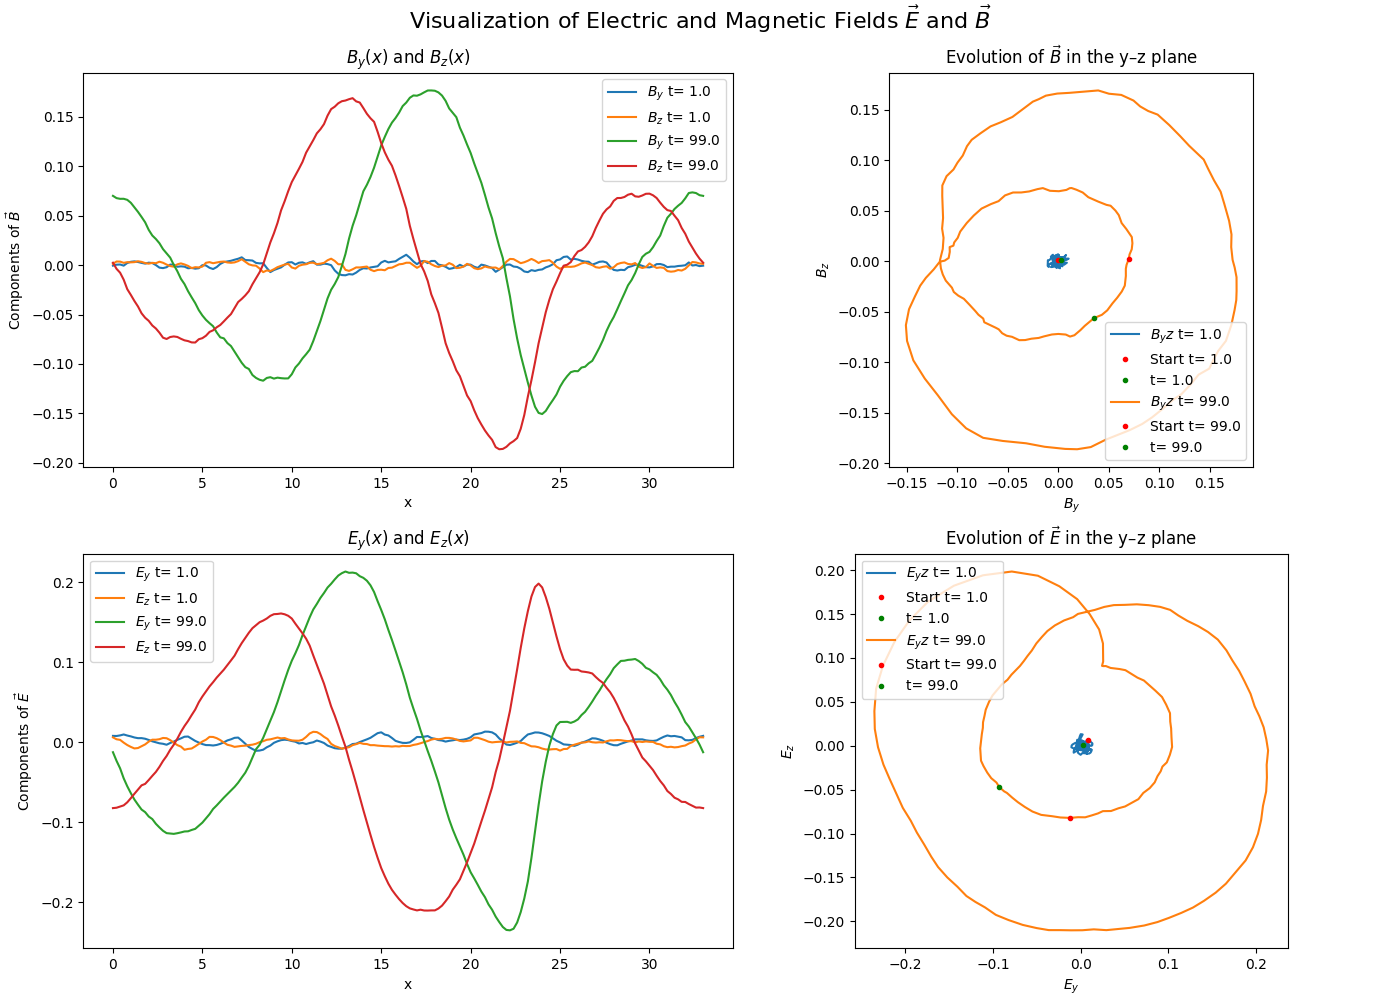

In [34]:
times = np.linspace(1, 99, 2)
plot_polar_byz_eyz(r, times, sigma=0)

The different figures above gives information on the electric and magnetic fields evolve. Both field has a circular polarization, and they are rotating clockwise when looking in the propagation wave direction.

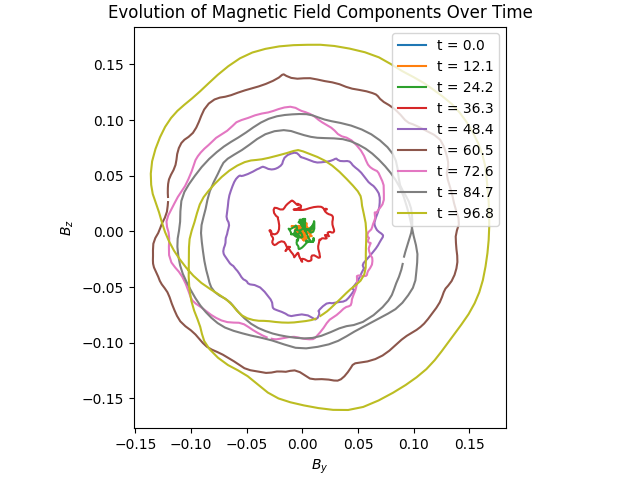

In [35]:
times = np.arange(0, 99.9, 12.1)
plot_polar_b(r, times, sigma=1)

## Find the growth rate of the most unstable mode

this is an offset so the exponential fit associated to the linear phase is not performed until the time at which the B value gets the greater... but is rather before with an offset given by `time_offset` : the exponential fit is performed on `[0, times[imax] - time_offset]`

Text(0, 0.5, 'Amplitude')

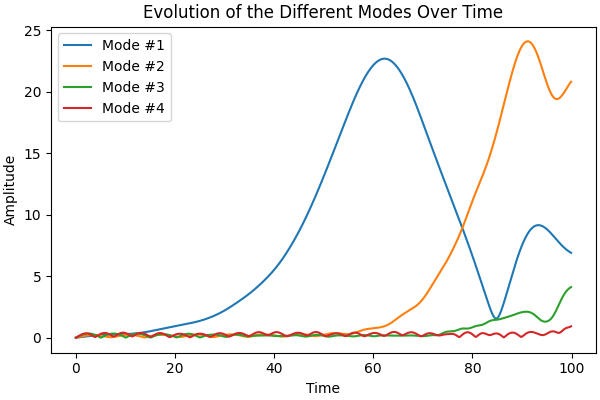

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)

for i in range(4):
    mode, times = modes_right(path, i)
    ax.plot(times, mode, label=f"Mode #{i + 1}")
ax.legend()
ax.set_title("Evolution of the Different Modes Over Time")
ax.set_xlabel("Time")
ax.set_ylabel("Amplitude")

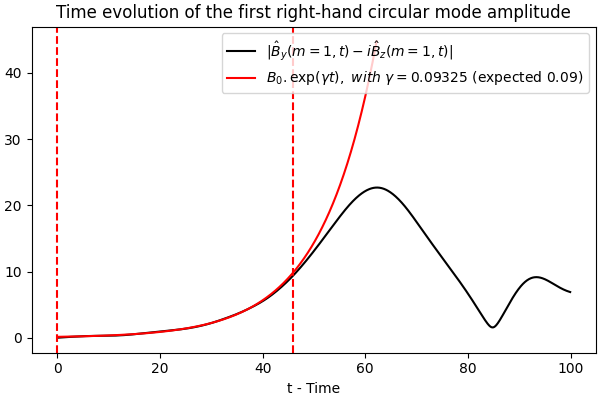

In [37]:
time_offset = 23 #Max 23.29 (or 23.299999999999)
times, first_mode, ampl, gamma, damped_mode, omega = growth_b_right_hand(
    path, time_offset, 0)
growth_plot(r, path, time_offset)

$k_n = \frac{2 \pi n}{L_{ength}} = \frac{2 \pi}{\lambda}$.
For $k_1$, we have : $$k_1 = \frac{2 \pi}{L_{ength}} \ \text{so} \ \lambda_1 = {L_{ength}}$$ 

In [38]:
num = 0
mode, times = modes_right(path, num)
imax = find_peaks(mode)[0][0]
p, c = curve_fit(yaebx, times[:imax-100], mode[:imax-100],p0=[0.08,0.09])
ampli, gamma = p
a = mode
b = yaebx(times, ampli, gamma)
diff = a-b
for i in range(diff.size):
    if np.abs(diff[i]) > 0.5:
        break

Text(0, 0.5, 'Amplitude')

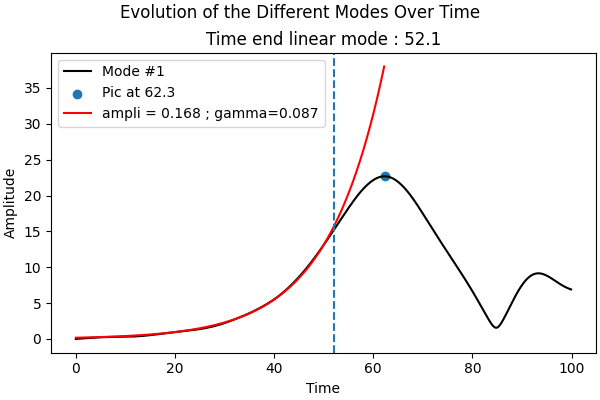

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
ax.plot(times, mode, label=f"Mode #{num+1}", c="black")
ax.scatter(times[imax], mode[imax], label=f"Pic at {times[imax]}")
ax.set_title(f"Time end linear mode : {times[i]}")
ax.plot(times[:imax], yaebx(times[:imax],ampli, gamma), label=f"ampli = {ampli:.3f} ; gamma={gamma:.3f}", c="red", ls="-")
ax.axvline(times[i], ls="--")
ax.legend()
fig.suptitle("Evolution of the Different Modes Over Time")
ax.set_xlabel("Time")
ax.set_ylabel("Amplitude")

In [40]:
num = 1
mode, times = modes_right(path, num)
imax = find_peaks(mode)[0][8]
p, c = curve_fit(yaebx, times[:imax-100], mode[:imax-100],p0=[0.08,0.09])
ampli, gamma = p
a = mode
b = yaebx(times, ampli, gamma)
diff = a-b
for i in range(diff.size):
    if np.abs(diff[i]) > 0.5:
        break

Text(0, 0.5, 'Amplitude')

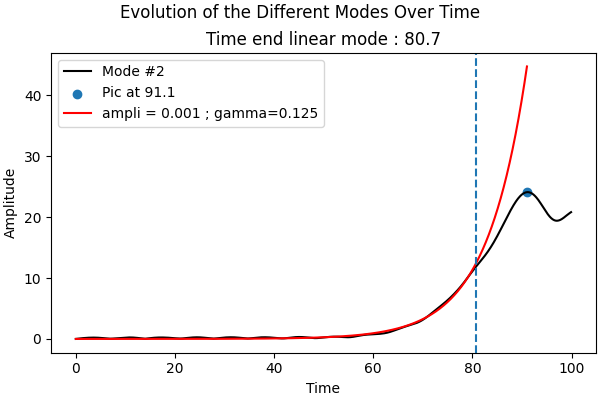

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
ax.plot(times, mode, label=f"Mode #{num+1}", c="black")
ax.scatter(times[imax], mode[imax], label=f"Pic at {times[imax]}")
ax.set_title(f"Time end linear mode : {times[i]}")
ax.plot(times[:imax], yaebx(times[:imax],ampli, gamma), label=f"ampli = {ampli:.3f} ; gamma={gamma:.3f}", c="red", ls="-")
ax.axvline(times[i], ls="--")
ax.legend()
fig.suptitle("Evolution of the Different Modes Over Time")
ax.set_xlabel("Time")
ax.set_ylabel("Amplitude")

In [42]:
l = r.GetDomainSize()[0]
K = 2*np.pi/l
v_p = omega/K
print("lambda = ", l)
print("Omega = ", omega)
print("k = ", K)
print("Phase speed =", v_p)

lambda =  33.0
Omega =  0.24042800920330049
k =  0.19039955476301776
Phase speed = 1.2627551020408163


In [43]:
time = [60]

ex, ey, ez , x = get_E(r, time, sigma=0)

fs, x , energie_mode = fourier_series(r, time, 1, field="E", direction = "y")
energie_total = np.sum(ey.real**2/2)
energie_mode = np.sum(fs.real**2/2)
rate = energie_mode*100/energie_total

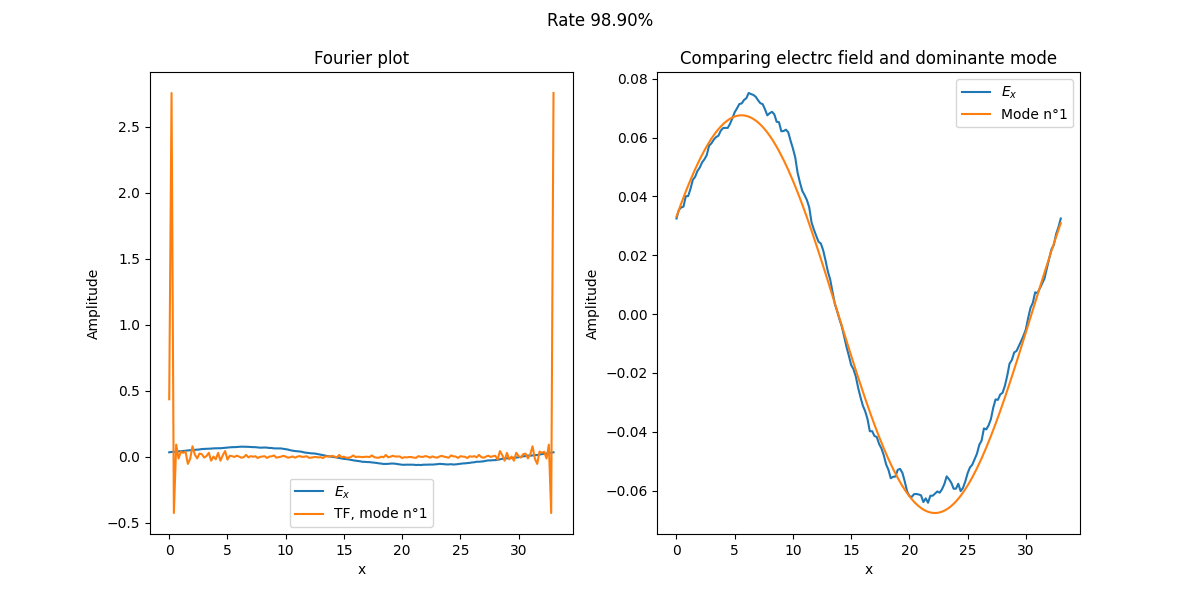

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle(f"Rate {rate:.2f}%")

ax[0].set_title("Fourier plot")
ax[0].set_xlabel("x")
ax[0].set_ylabel("Amplitude")
ax[0].plot(x, ey, label="$E_x$")
ax[0].plot(x, np.fft.fft(ey, axis=0), label=f"TF, mode n°1")

ax[1].set_title("Comparing electrc field and dominante mode")
ax[1].set_xlabel("x")
ax[1].set_ylabel("Amplitude")
ax[1].plot(x, ey, label="$E_x$")
ax[1].plot(x, fs, label=f"Mode n°1")
ax[0].legend()
ax[1].legend()

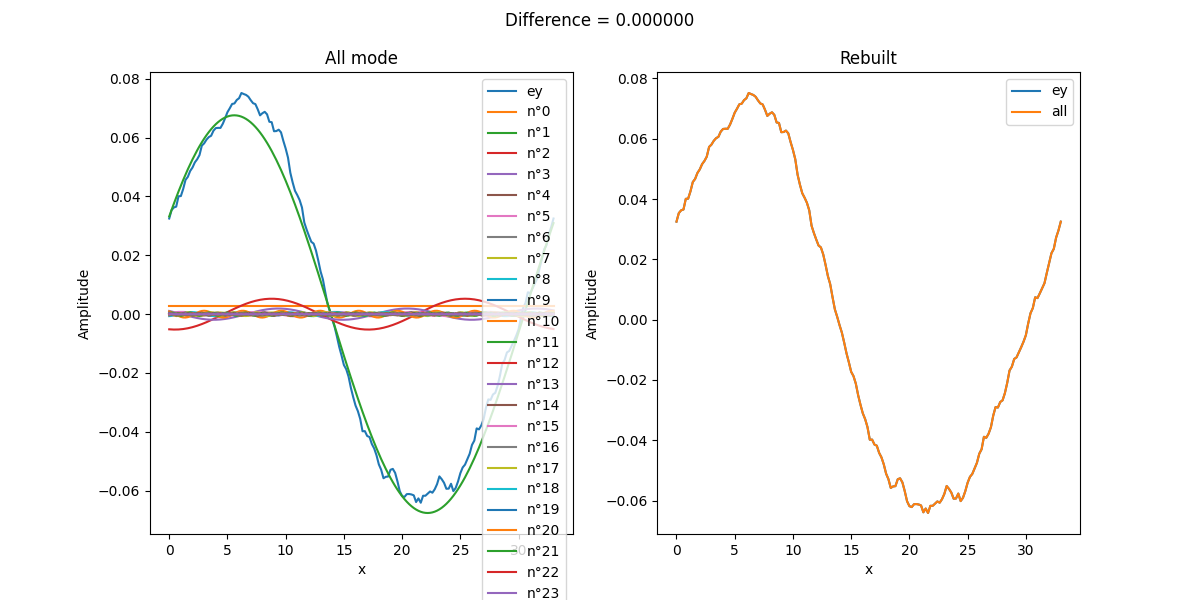

In [45]:
ex, ey, ez , x = get_E(r, time, sigma=0)

ey_k = np.fft.fft(ey, axis = 0)
all = np.zeros_like(ey_k, dtype=complex)

fig, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].plot(x, ey, label="ey")
ax[1].plot(x, ey, label="ey")

for i in range(ey_k.size //2+1):
    mode_indice = i
    ey_k_i = np.zeros_like(ey_k, dtype= complex)
    
    ey_k_i[mode_indice,:] = ey_k[mode_indice,:]
    ey_k_i[-mode_indice, :] = ey_k[-mode_indice, :]
    
    ek = np.fft.ifft(ey_k_i, axis = 0)
    all += ek
    ax[0].plot(x, ek, label=f"n°{i}")


ax[0].legend()
ax[0].set_title("All mode")
ax[0].set_xlabel("x")
ax[0].set_ylabel("Amplitude")

ax[1].set_title("Rebuilt")
ax[1].plot(x, all, label = "all")
ax[1].set_xlabel("x")
ax[1].set_ylabel("Amplitude")
fig.suptitle(f"Difference = {np.sum(np.abs(all.real - ey.real))/all.size:.6f}")
ax[1].legend()

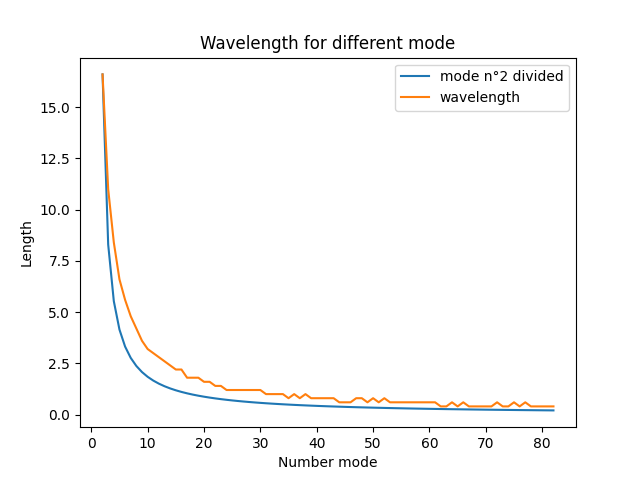

In [46]:
time = [99]
dt = 0.1
dx = []

m, n, o = fourier_series(r, time, 2,  field="E", direction = "x")
p = find_peaks(m[:,0])[0][0]
w = find_peaks(m[:,0])[0][1]
dy = []

for i in range(2, int(r.GetDomainSize()/(0.2*2)+1)):
    fs, x , energy = fourier_series(r, time, i, field="E", direction = "x")
    peaks = find_peaks(gf(fs[:,0], 1))[0]
    a = peaks[0]
    b = peaks[1]
    dx.append(x[b]-x[a])
    dy.append((n[w]-n[p])/(i-1))

l = np.arange(2, int(r.GetDomainSize()/(0.2*2)+1), 1)
fig, ax = plt.subplots(1,1)
ax.set_title("Wavelength for different mode")
ax.set_xlabel("Number mode")
ax.set_ylabel("Length")
ax.plot(l,dy, label="mode n°2 divided")
ax.plot(l,dx, label="wavelength")
ax.legend()

# y(k) and a(k)

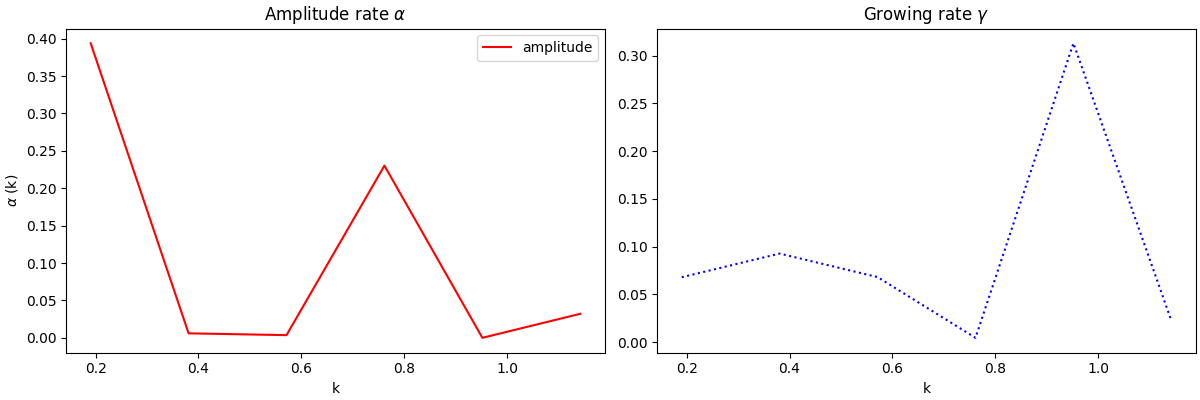

In [47]:
amplitude, g = plot_ampli_gamma(r, 6)

# First mode vs second mode

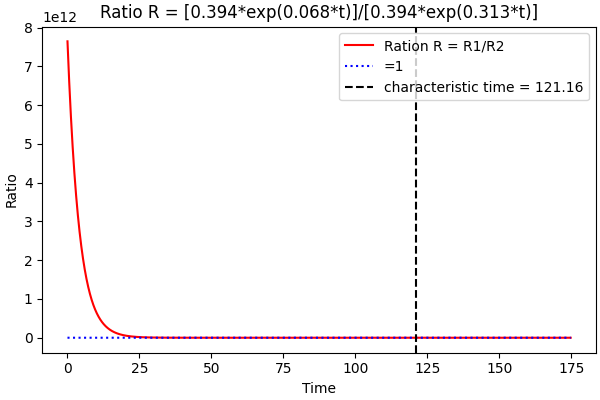

In [48]:
plot_comparative_mode(r, amplitude[0], amplitude[4], g[0], g[4])

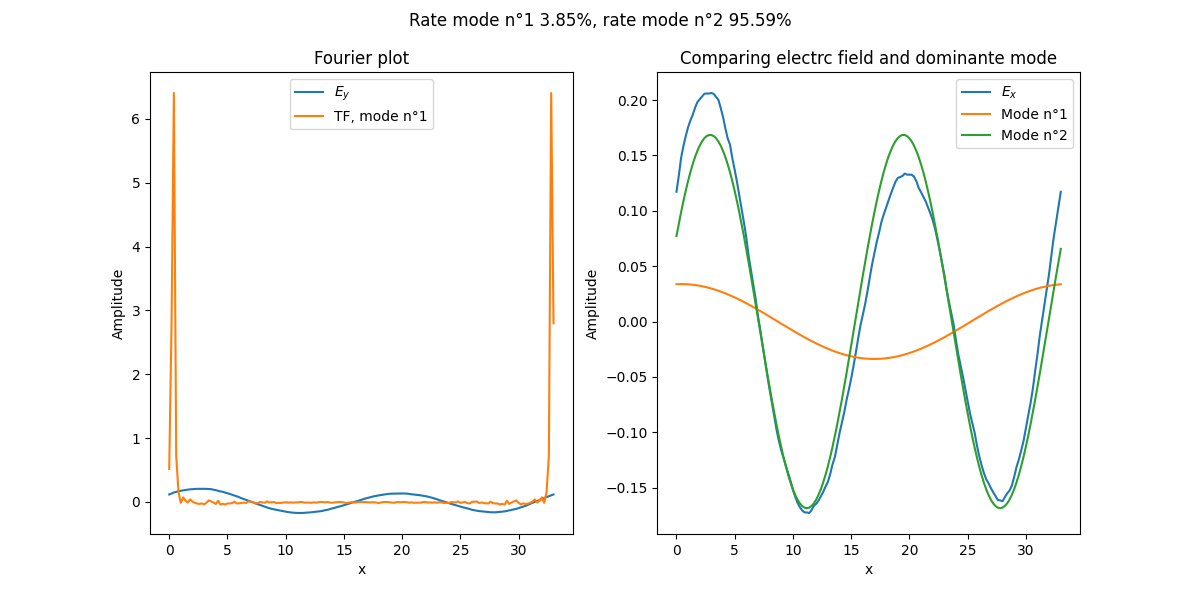

In [49]:
time = [91.1]

ex, ey, ez , x = get_E(r, time, sigma=0)

fs1, x , energie_mode = fourier_series(r, time, 1, field="E", direction = "y")
energie_total = np.sum(ey.real**2/2)
energie_mode = np.sum(fs1.real**2/2)
rate1 = energie_mode*100/energie_total
fs2, x , energie_mode = fourier_series(r, time, 2, field="E", direction = "y")
energie_total = np.sum(ey.real**2/2)
energie_mode = np.sum(fs2.real**2/2)
rate2 = energie_mode*100/energie_total

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle(f"Rate mode n°1 {rate1:.2f}%, rate mode n°2 {rate2:.2f}%")

ax[0].set_title("Fourier plot")
ax[0].set_xlabel("x")
ax[0].set_ylabel("Amplitude")
ax[0].plot(x, ey, label="$E_y$")
ax[0].plot(x, np.fft.fft(ey, axis=0), label=f"TF, mode n°1")

ax[1].set_title("Comparing electrc field and dominante mode")
ax[1].set_xlabel("x")
ax[1].set_ylabel("Amplitude")
ax[1].plot(x, ey, label="$E_x$")
ax[1].plot(x, fs1, label=f"Mode n°1")
ax[1].plot(x, fs2, label=f"Mode n°2")
ax[0].legend()
ax[1].legend()

# Phase velocity and omega 

Because this relation has the shape of $k/\omega = -c_s$ (and not $k/\omega = +c_s$), this mode is a AIC mode

/opt/conda/envs/hpc/lib/python3.10/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


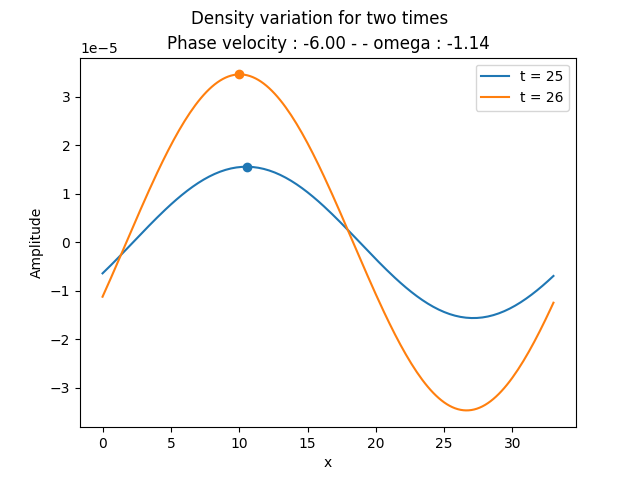

In [50]:
time = np.asarray([25, 26])
dt = 0.1
fs, x, energy = fourier_series(r, time, 1, field="E", direction="x")
x1 = find_peaks(fs[:,0])[0][0]
x2 = find_peaks(fs[:,1])[0][0]
dx = x[x2]-x[x1]
v = dx/dt

k = 2*np.pi/r.GetDomainSize()[0]
w = k*v
fig, ax = plt.subplots(1,1)
fig.suptitle("Density variation for two times")
ax.plot(x, fs[:,0], label =f"t = {time[0]}")
ax.plot(x, fs[:,1], label=f"t = {time[1]}")
ax.set_title(f"Phase velocity : {v:.2f} - - omega : {w :.2f}")
ax.set_ylabel("Amplitude")
ax.set_xlabel("x")
ax.scatter(x[x1], fs[x1, 0])
ax.scatter(x[x2], fs[x2, 1])
ax.legend()

# Pressure

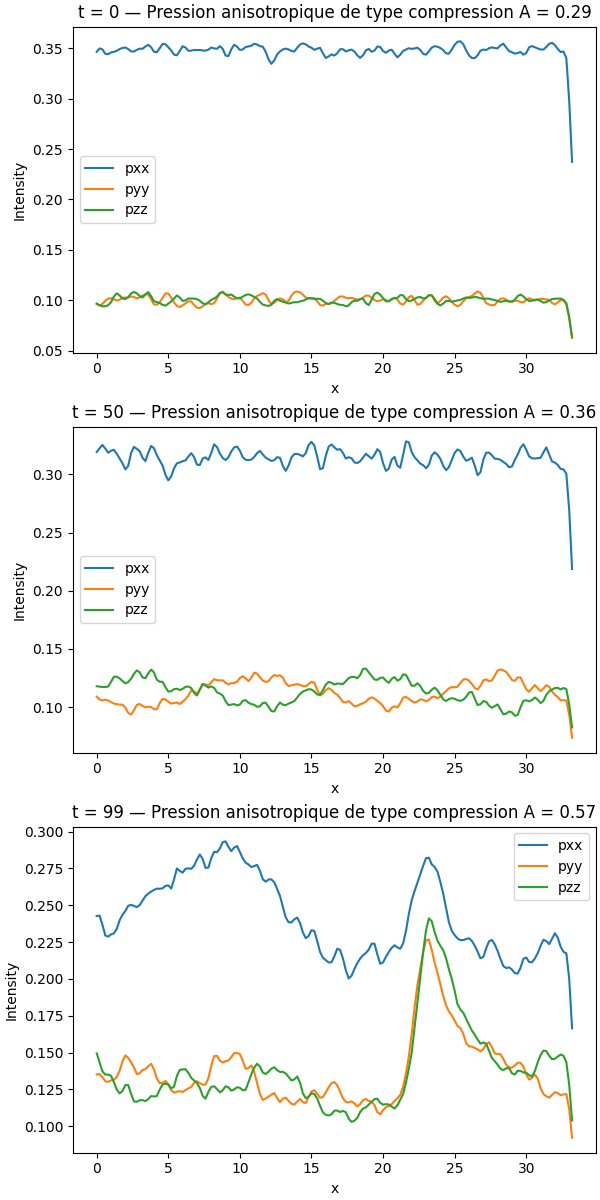

In [51]:
times = np.array([0, 50, 99])  
plot_pressure(r, times, 1)

# Electrostatic and Electromagnetic case

In [52]:
path = root_path + "/" + "ibtest"
r = Run(path)

(<Figure size 1400x600 with 4 Axes>,
 (<Axes: title={'center': 'Distribution for t = 0'}, xlabel='Vx', ylabel='Vy'>,
  <Axes: title={'center': 'Distribution for t = 99'}, xlabel='Vx', ylabel='Vy'>))

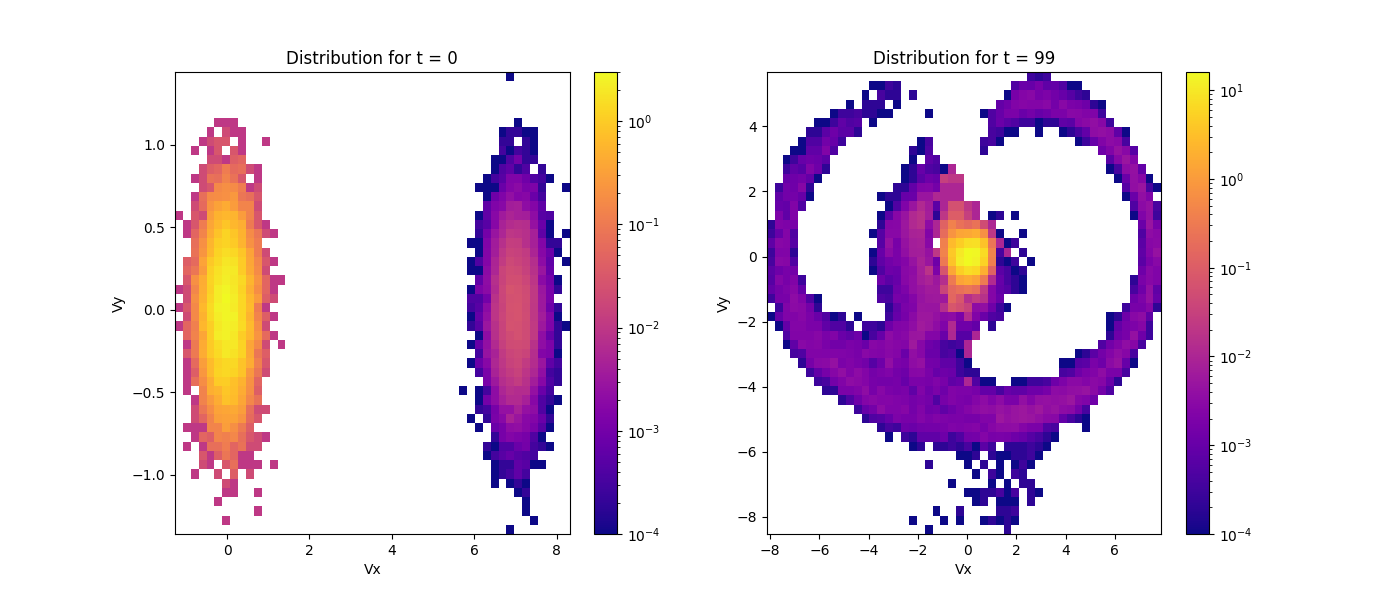

In [53]:
compare_dist_plots(r, "both", axis=("Vx", "Vy"), cmap="plasma")

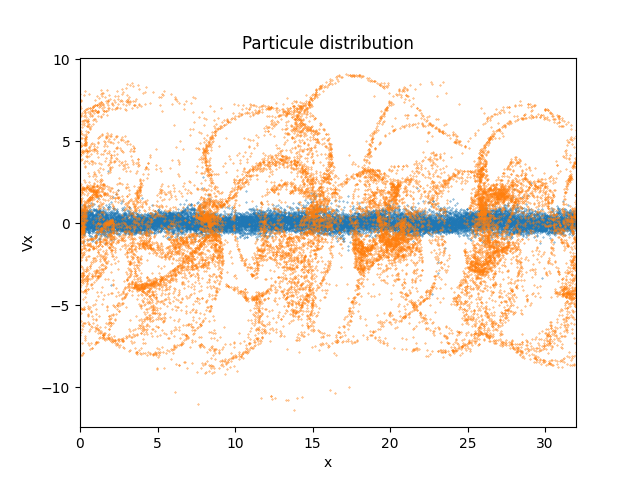

In [54]:
time = 199
main = r.GetParticles(time, ["main"])
beam = r.GetParticles(time, ["beam"])
both = r.GetParticles(time, ["main", "beam"])
x_, v_ = dist_plot(both, axis=("x", "Vx"), plot_type="scatter_2", title="Particule distribution")

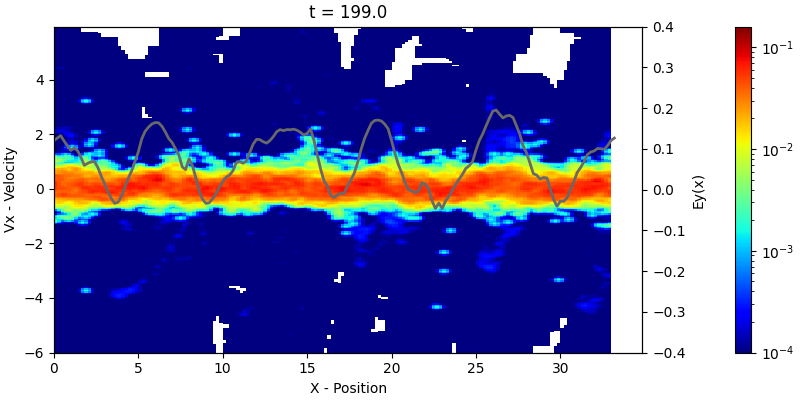

In [55]:
phase_space_ey(199, r) #Max time_offset = 99.9

In [56]:
times = np.linspace(0, 99, 2)

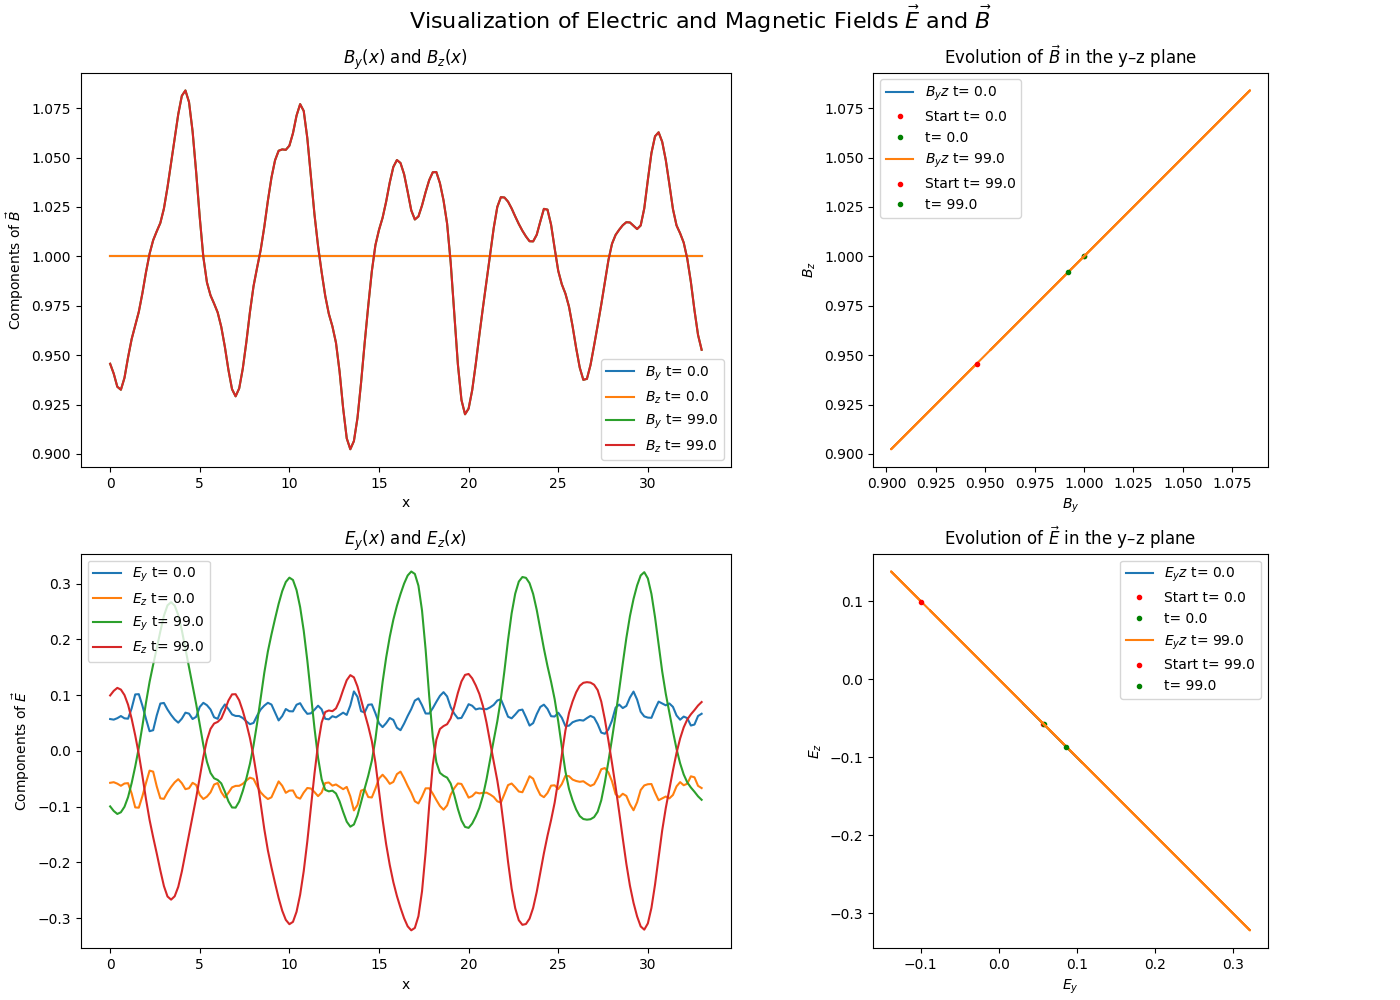

In [57]:
plot_polar_byz_eyz(r, times)

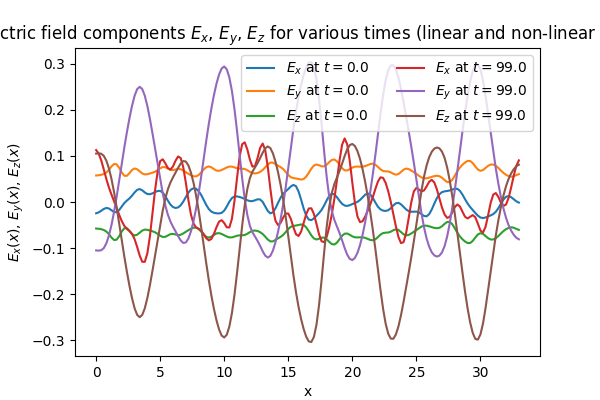

In [58]:
plot_Exyz(r, times)

Text(0.5, 1.0, 'Magnetic Field Components Over Time t=150')

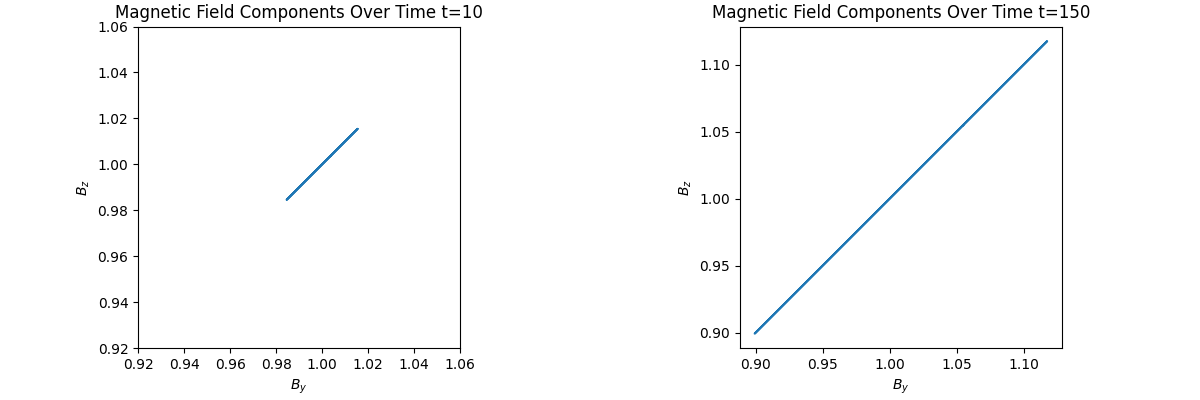

In [59]:
times = np.array([10, 150])
fig1, ax = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
fig.suptitle("Magnetic field evolving")

bx, by, bz, x = get_B(r, times)

ax[0].plot(by[:,0], bz[:,0])
ax[0].set_xlabel("$B_y$")
ax[0].set_xlim(0.92, 1.06)
ax[0].set_ylabel("$B_z$")
ax[0].set_ylim(0.92, 1.06)
ax[0].set_aspect("equal", adjustable="box")
ax[0].set_title(f"Magnetic Field Components Over Time t={times[0]}")

ax[1].plot(by[:,1], bz[:,1])
ax[1].set_xlabel("$B_y$")
ax[1].set_ylabel("$B_z$")
ax[1].set_aspect("equal", adjustable="box")
ax[1].set_title(f"Magnetic Field Components Over Time t={times[1]}")


Text(0, 0.5, 'Amplitude')

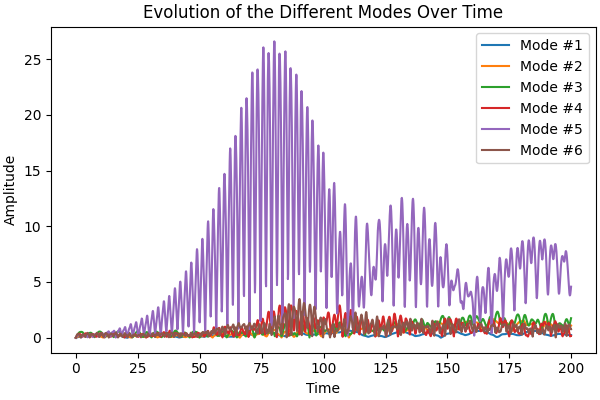

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)

for i in range(6):
    mode, times = modes_right(path, i)
    ax.plot(times, mode, label=f"Mode #{i + 1}")

ax.legend()
ax.set_title("Evolution of the Different Modes Over Time")
ax.set_xlabel("Time")
ax.set_ylabel("Amplitude")

Text(0, 0.5, 'Amplitude')

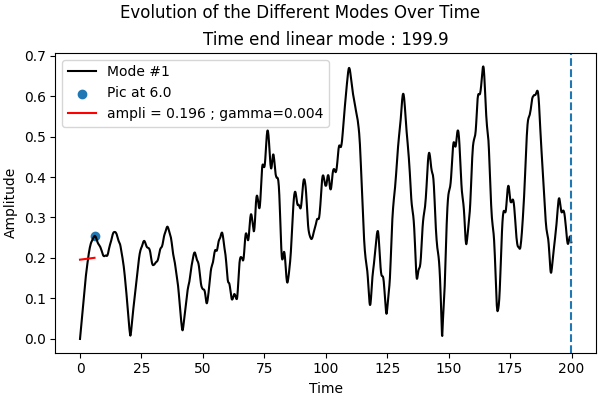

In [61]:
num = 0
mode, times = modes_right(path, num)
imax = find_peaks(mode)[0][0]
p, c = curve_fit(yaebx, times[:imax-100], mode[:imax-100],p0=[0.08,0.09])
ampli, gamma = p
a = mode
b = yaebx(times, ampli, gamma)
diff = a-b
for i in range(diff.size):
    if np.abs(diff[i]) > 0.5:
        break
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
ax.plot(times, mode, label=f"Mode #{num+1}", c="black")
ax.scatter(times[imax], mode[imax], label=f"Pic at {times[imax]}")
ax.set_title(f"Time end linear mode : {times[i]}")
ax.plot(times[:imax], yaebx(times[:imax],ampli, gamma), label=f"ampli = {ampli:.3f} ; gamma={gamma:.3f}", c="red", ls="-")
ax.axvline(times[i], ls="--")
ax.legend()
fig.suptitle("Evolution of the Different Modes Over Time")
ax.set_xlabel("Time")
ax.set_ylabel("Amplitude")

In [62]:
time = [92]

ex, ey, ez , x = get_E(r, time, sigma=0)

fs, x , energie_mode = fourier_series(r, time, 1, field="E", direction = "y")
energie_total = np.sum(ey.real**2/2)
energie_mode = np.sum(fs.real**2/2)
rate = energie_mode*100/energie_total

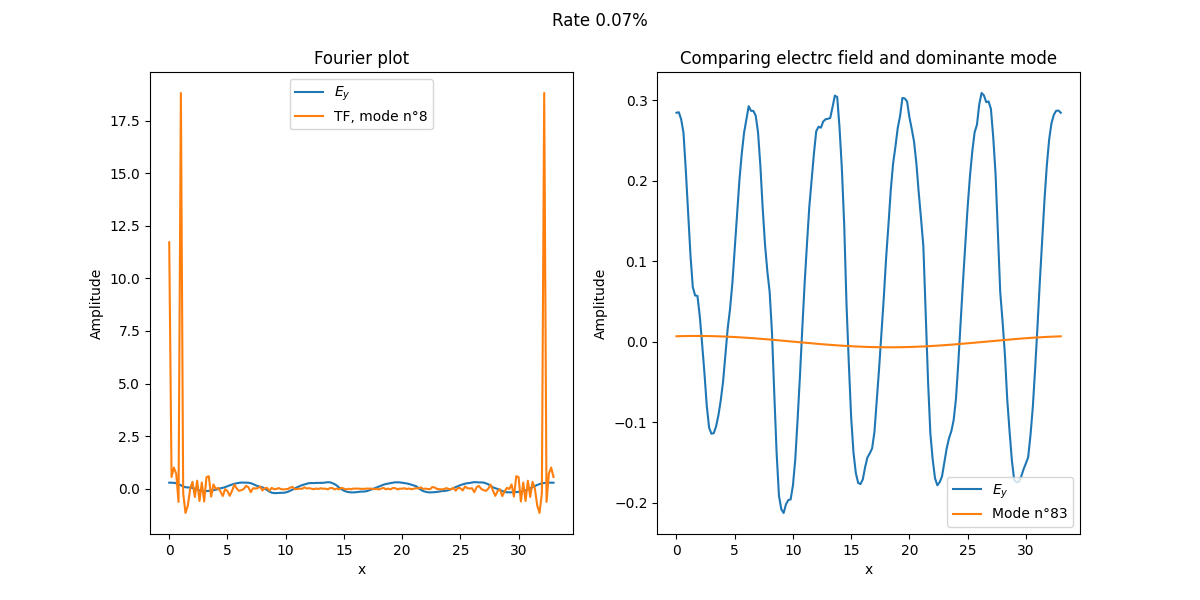

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle(f"Rate {rate:.2f}%")

ax[0].set_title("Fourier plot")
ax[0].set_xlabel("x")
ax[0].set_ylabel("Amplitude")
ax[0].plot(x, ey, label="$E_y$")
ax[0].plot(x, np.fft.fft(ey, axis=0), label=f"TF, mode n°{np.argmax(np.abs((fs[:(fs.size // 2)])))}")

ax[1].set_title("Comparing electrc field and dominante mode")
ax[1].set_xlabel("x")
ax[1].set_ylabel("Amplitude")
ax[1].plot(x, ey, label="$E_y$")
ax[1].plot(x, fs, label=f"Mode n°{mode_indice}")
ax[0].legend()
ax[1].legend()

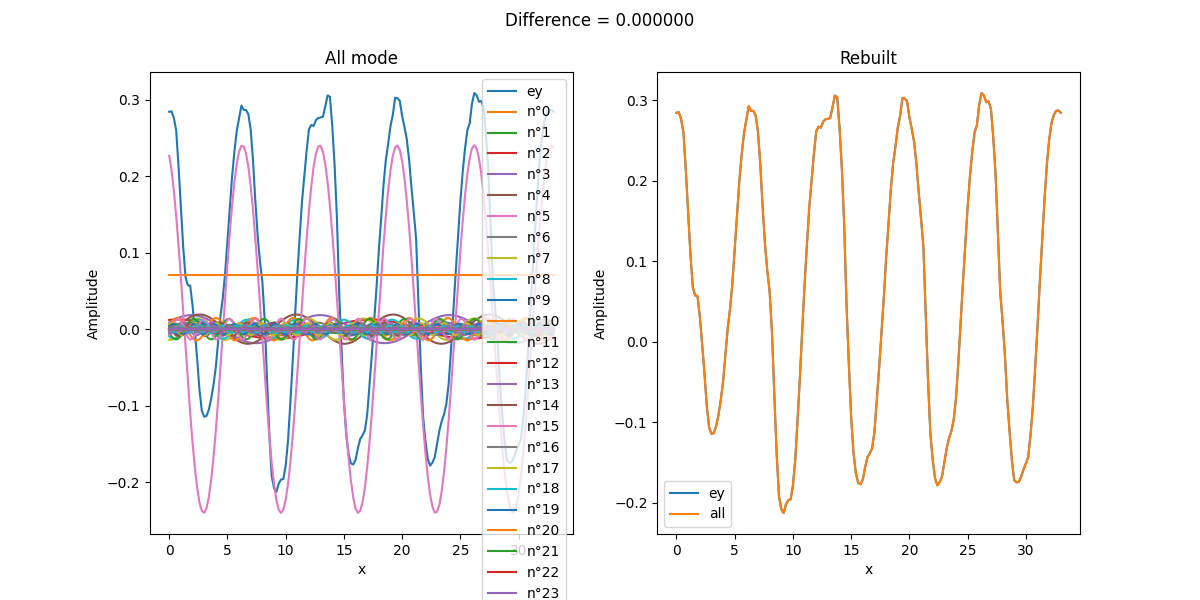

In [64]:
ex, ey, ez , x = get_E(r, time, sigma=0)

ey_k = np.fft.fft(ey, axis = 0)
all = np.zeros_like(ey_k, dtype=complex)

fig, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].plot(x, ey, label="ey")
ax[1].plot(x, ey, label="ey")

for i in range(ey_k.size //2+1):
    mode_indice = i
    ey_k_i = np.zeros_like(ey_k, dtype= complex)
    
    ey_k_i[mode_indice,:] = ey_k[mode_indice,:]
    ey_k_i[-mode_indice, :] = ey_k[-mode_indice, :]
    
    ek = np.fft.ifft(ey_k_i, axis = 0)
    all += ek
    ax[0].plot(x, ek, label=f"n°{i}")


ax[0].legend()
ax[0].set_title("All mode")
ax[0].set_xlabel("x")
ax[0].set_ylabel("Amplitude")

ax[1].set_title("Rebuilt")
ax[1].plot(x, all, label = "all")
ax[1].set_xlabel("x")
ax[1].set_ylabel("Amplitude")
fig.suptitle(f"Difference = {np.sum(np.abs(all.real - ey.real))/all.size:.6f}")
ax[1].legend()

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8), constrained_layout=True)

for i in range(7):
    mode, times = modes_E(path, i)
    ax[0].plot(times, mode, label=f"mode n°{i+1}")
file = os.path.join(r.path, "EM_B.h5")
times = fromh5.get_times_from_h5(file)
ex, ey, ez, x = get_E(r, times, sigma = 0)
z = 16
ax[1].set_title("Electric field Ex for one position")
ax[1].plot(times, ex[z,:])
ax[1].set_xlabel("x")
ax[1].set_ylabel("Amplitude")
ax[0].legend()
ax[0].set_ylabel("Amplitude")
ax[0].set_title("Growing of the different modes")
ax[0].set_xlabel("Time")

# Vecteur de Poynting / Electromagnetic energy / Current

# Etude de la densité

In [ ]:
from matplotlib.animation import FuncAnimation

file = os.path.join(path, "EM_B.h5")
times = fromh5.get_times_from_h5(file)  # Was get_times_from_h5 #Was none
dt = times[1] - times[0]

# Données
xM, mt = get_massDensity(r, times, sigma = 0)  

# Préparation de la figure
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
line, = ax.plot([], [], lw=2, color='royalblue')
title = ax.set_title("")

ax.set_xlim(xM.min(), xM.max())
ax.set_ylim(np.min(mt), np.max(mt))
ax.set_xlabel("Position")
ax.set_ylabel("Masse volumique")

# Initialisation
def init():
    line.set_data([], [])
    title.set_text("")
    return line, title

# Animation
def update(i):
    line.set_data(xM, mt[:, i])
    title.set_text(f"Density variations throw time t = {times[i]:.1f}")
    return line, title

ani = FuncAnimation(
    fig, update, frames=len(times), init_func=init,
    interval=50, blit=True
)

plt.show()

# Etude de la pression

In [ ]:
times = np.asarray([1, 20, 50, 60, 150, 199])
plot_pressure(r, times, 0.1)